# Maillage dataset

## Import libraries and load dataset

In [2]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd

## Read data

In [3]:
maritime_data = pd.read_csv("./Atlantic_bathymetry/atlantic_treated_data.csv", sep=",", header=2)
earth_data = pd.read_csv("./Topography_arcachon/earth_data3.xyz", sep=",", header=3)

## Process datas
Transform csv data to numpy arrays to be plotted

Correct for real depth (opposite of dataset depth), and translate to the average tide of $1.980m$ for Arcachon Basin

In [4]:
maritime_data = maritime_data.rename(columns={"long(DD)": "long", "lat(DD)": "lat", "depth(m - down positive - LAT)": "depth"})
maritime_data["depth"] = maritime_data["depth"]+1.9860

maritime_depth = maritime_data["depth"]
maritime_long = maritime_data["long"].to_numpy()
maritime_lat = maritime_data["lat"].to_numpy()

earth_data=pd.DataFrame(np.array(earth_data),columns=['lat','long','depth','iteration'])
earth_depth = earth_data["depth"].to_numpy()
earth_long = earth_data["long"].to_numpy()
earth_lat = earth_data["lat"].to_numpy()

## Changing scale

In [5]:
maritime_depth = maritime_depth*10
maritime_long = maritime_long*111000        
maritime_lat = maritime_lat*111000           

earth_depth=earth_depth*10
earth_lat=earth_lat*111000
earth_long=earth_long*111000

## Plot maritime data

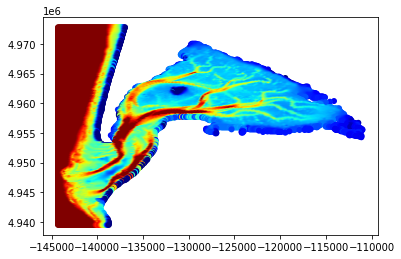

In [6]:
plt.figure()
plt.scatter(maritime_long, maritime_lat, c=-maritime_depth, cmap="jet",linewidths=0.00000005)
plt.clim(vmin=-100,vmax=100)
plt.show()


## Plot earth data

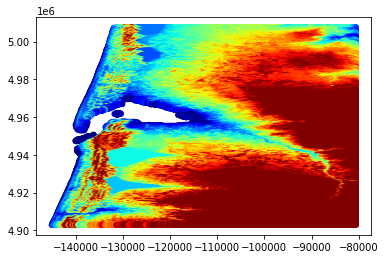

In [7]:
plt.figure()
plt.scatter(earth_long, earth_lat, c=earth_depth, cmap="jet",linewidths=0.00000005)
plt.clim(vmin=0,vmax=500)
plt.show()

## Maillage

In [8]:
import pyvista as pv
import vtk

options=0 # 0: earth+maritime, 1: earth, other cases: maritime

if options==0: # it needs to fix the reference on Image_data
    long=np.concatenate((maritime_long,earth_long))
    lat=np.concatenate((maritime_lat,earth_lat))
    depth=np.concatenate((maritime_depth,earth_depth))
elif options==1:
    long=earth_long
    lat=earth_lat
    depth=earth_depth
else :
    long=maritime_long
    lat=maritime_lat
    depth=maritime_depth

points = np.array([long,lat,depth]).T
cloud = pv.PolyData(points)
grid = cloud.delaunay_2d(alpha=400)   # We use the Delaunay method to make the mesh

# Coloring the vtk file
colors = vtk.vtkIntArray()
colors.SetName("Colors")
temp = [i for i in range(0,grid.number_of_cells)]
for t in temp:
    colors.InsertNextValue(t)
    
grid2=pv.PolyData()
grid2.shallow_copy(grid)  

grid.GetCellData().SetScalars(colors)
grid.GetPointData().SetScalars(colors)

#Ploting
grid.plot(show_edges=True)
grid.save('mesh.vtk')


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)